Założenia treningu:
### **Dane**
- Zbiór: **CIFAR-10**
- Liczba obrazów:
    - **50 000** – trening
    - **10 000** – test
- Liczba klas: **10**
- Oryginalny rozmiar obrazka: **32 × 32 × 3 (RGB)**

### **Transformacje danych (train)**

1. **RandomHorizontalFlip** – losowe odbicie poziome (augmentacja)
2. **Resize(224×224)** – powiększenie obrazu do wymaganego wejścia MobileNetV2 (interpolacja)
3. **ToTensor()** – zamiana pikseli na tensory, skala 0–1
4. **Normalize(mean, std)** – normalizacja z wartościami CIFAR-10

### **Model**

- Architektura: **MobileNetV2**
- Wagi startowe: **IMAGENET1K_V1 (pretrained)**
- Modyfikacja:
    - Zmieniona ostatnia warstwa (`classifier[1]`) na **10 wyjść** (10 klas CIFAR-10)

### **Konfiguracja treningu**

- `batch_size = 128`
- Funkcja straty: **CrossEntropyLoss**
- Optymalizator: **Adam**, `lr = 1e-3`
- Akcelerator: **GPU (Tesla T4 – Colab)**
- Liczba epok: **5** (na start)

### **Wynik treningu**

- Zapis wag modelu: **`.pth`**
- Eksport do formatu **ONNX**:
    
    **`mobilenetv2_cifar10.onnx`**

Import bibliotek

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Przygotowanie danych CIFAR-10

In [ ]:
# Transformacje danych (zmiana rozmiaru + zamiana na tensor + normalizacja)
transform_train = transforms.Compose([
    transforms.Resize(224),           # MobileNetV2 oczekuje 224x224
    transforms.RandomHorizontalFlip(),# lekkie augmentacje
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

# Pobranie CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# DataLoadery – "podajniki" danych dla modelu
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

len(train_dataset), len(test_dataset)


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


(50000, 10000)

Prezentacja danych CIFAR-10

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes
classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

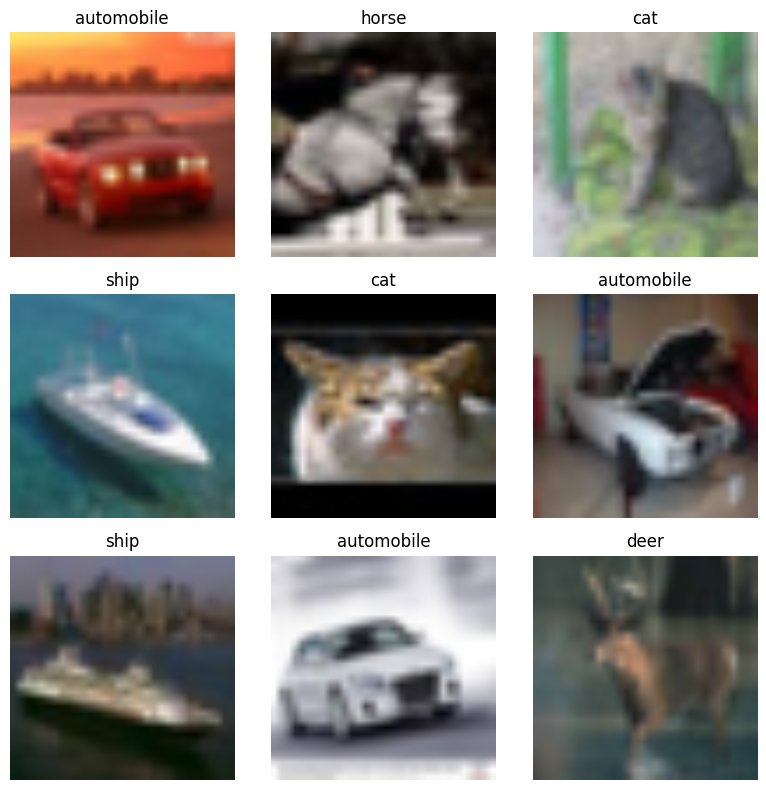

In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # "od-normalizujemy" do [0,1]
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")

# pobieramy 1 batch
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.show()


Definicja modelu MobileNetV2

In [ ]:
from torchvision.models import mobilenet_v2

# Wersja z pretrenowaniem na ImageNet - dzięki temu nauka nowego modelu jest szybsza
model = mobilenet_v2(weights="IMAGENET1K_V1")

# Podmieniamy ostatnią warstwę na 10 klas CIFAR-10
model.classifier[1] = nn.Linear(model.last_channel, 10)

model = model.to(device)

# Sprawdźmy liczbę parametrów
num_params = sum(p.numel() for p in model.parameters())
print(f"Liczba parametrów: {num_params/1e6:.2f}M")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 211MB/s]


Liczba parametrów: 2.24M


Ustawienie funkcjię straty i optymailzator

In [ ]:
criterion = nn.CrossEntropyLoss()                # typowa funkcja straty do klasyfikacji
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam z lr = 0.001


Funkcję do tranowania oraz do ewaliacji modelu

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

Tranowanie modelu na wielu epokach

In [ ]:
num_epochs = 5  # na początek, można potem zwiększyć np. do 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoka {epoch+1}/{num_epochs}")
    print(f"  Train: loss={train_loss:.4f}, acc={train_acc:.2f}%")
    print(f"  Test : loss={val_loss:.4f}, acc={val_acc:.2f}%")

Epoka 1/5
  Train: loss=0.4385, acc=85.04%
  Test : loss=0.3971, acc=86.80%
Epoka 2/5
  Train: loss=0.2717, acc=90.86%
  Test : loss=0.3374, acc=88.95%
Epoka 3/5
  Train: loss=0.2231, acc=92.38%
  Test : loss=0.2849, acc=90.52%
Epoka 4/5
  Train: loss=0.1924, acc=93.35%
  Test : loss=0.2821, acc=90.79%
Epoka 5/5
  Train: loss=0.1682, acc=94.34%
  Test : loss=0.2636, acc=91.45%


Zapis wytrenowanego modelu

In [ ]:
!pip install onnx onnxscript
torch.save(model.state_dict(), "mobilenetv2_cifar10.pth")
print("Model zapisany jako mobilenetv2_cifar10.pth")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 16.9 MB/s eta 0:00:00
Model zapisany jako mobilenetv2_cifar10.pth


Eksport do ONNX

In [ ]:
model.eval()  # tryb ewaluacji

dummy_input = torch.randn(1, 3, 224, 224, device=device)  # przykładowe wejście

onnx_path = "mobilenetv2_cifar10.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=13
)

print(f"Model wyeksportowany do {onnx_path}")

/tmp/ipython-input-1490050521.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1206 19:31:32.229000 275 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 13 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 104 of general pattern rewrite rules.
Model wyeksportowany do mobilenetv2_cifar10.onnx


Pobranie ONNX

In [ ]:
from google.colab import files

files.download("mobilenetv2_cifar10.onnx")
files.download("mobilenetv2_cifar10.onnx.data")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# New Section